In [12]:
# 04_train_rul_energy.ipynb

import os
import sys

# Make project root importable: assumes this notebook is in amos/notebooks/
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("ggplot")

from src.config import (
    PROCESSED_DATA_PATH,
    RUL_MODEL_PATH,
    ENERGY_MODEL_PATH,
)
from src.preprocessing.etl import create_processed_dataset
from src.models.rul_model import (
    train_rul_regressor,
    save_rul_model,
    build_rul_target,
)
from src.models.energy_model import (
    train_energy_regressor,
    save_energy_model,
    build_energy_target,
)
from src.preprocessing.features import get_feature_columns


In [13]:
processed_path = create_processed_dataset(force=False)
print("Using processed data at:", processed_path)

df = pd.read_csv(PROCESSED_DATA_PATH)
df.head()


Using processed data at: /home/leo/AMOS/data/processed/ai4i2020_prepared.csv


,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF,Temp_diff,Power_proxy,Tool_wear_norm
0,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0,10.5,66382.8,0.000000
1,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0,10.5,65190.4,0.011858
2,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0,10.4,74001.2,0.019763
3,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0,10.4,56603.5,0.027668
4,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0,10.5,56320.0,0.035573


In [14]:
# RUL proxy
rul_target = build_rul_target(df)
print("RUL proxy stats:")
print(rul_target.describe())

# Energy proxy
energy_target = build_energy_target(df, k=1e-4)
print("\nEnergy proxy stats:")
print(energy_target.describe())


RUL proxy stats:
count    10000.000000
mean       145.049000
std         63.654147
min          0.000000
25%         91.000000
50%        145.000000
75%        200.000000
max        253.000000
Name: Tool wear [min], dtype: float64

Energy proxy stats:
count    10000.000000
mean         5.996715
std          1.019309
min          1.096680
25%          5.310540
50%          5.988390
75%          6.687375
max          9.998040
dtype: float64


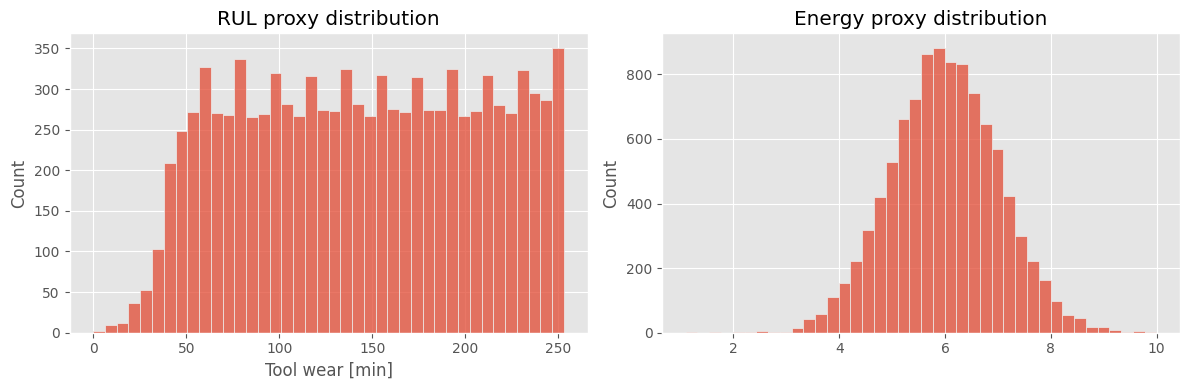

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(rul_target, bins=40, ax=ax[0])
ax[0].set_title("RUL proxy distribution")

sns.histplot(energy_target, bins=40, ax=ax[1])
ax[1].set_title("Energy proxy distribution")

plt.tight_layout()
plt.show()


In [16]:
rul_model, rul_metrics = train_rul_regressor(df)
print("RUL model trained.")
print("RUL metrics:", rul_metrics)


RUL model trained.
RUL metrics: {'mae': 0.0028900000000000024, 'r2': 0.9999991572685888}


RUL MAE: 0.0028900000000000024
RUL R^2: 0.9999991572685888


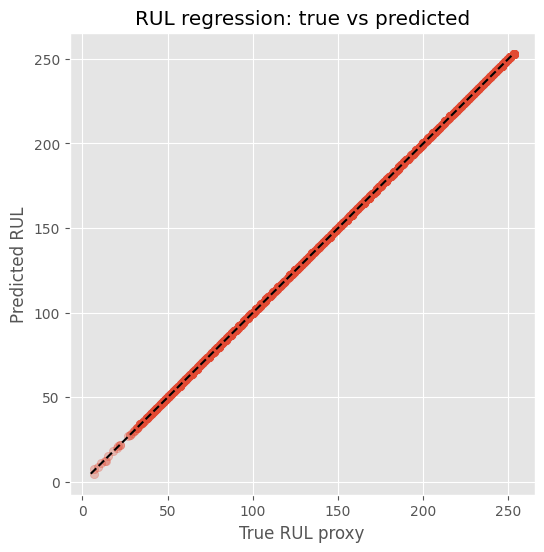

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

# Rebuild data splits explicitly just for plotting
y = build_rul_target(df)
X_raw, _, _ = get_feature_columns(df)

X_train, X_test, y_train, y_test = train_test_split(
    X_raw, y, test_size=0.2, random_state=42
)

y_pred = rul_model.predict(X_test)

print("RUL MAE:", mean_absolute_error(y_test, y_pred))
print("RUL R^2:", r2_score(y_test, y_pred))

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel("True RUL proxy")
plt.ylabel("Predicted RUL")
plt.title("RUL regression: true vs predicted")
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], "k--")
plt.show()


In [18]:
save_rul_model(rul_model, RUL_MODEL_PATH)
print("RUL model saved to:", RUL_MODEL_PATH)


RUL model saved to: /home/leo/AMOS/models/rul/rul_regressor.pkl


In [19]:
energy_model, energy_metrics = train_energy_regressor(df)
print("Energy model trained.")
print("Energy metrics:", energy_metrics)


Energy model trained.
Energy metrics: {'mae': 0.0012259255833340621, 'r2': 0.9998232831334793}


Energy MAE: 0.0012259255833340634
Energy R^2: 0.9998232831334793


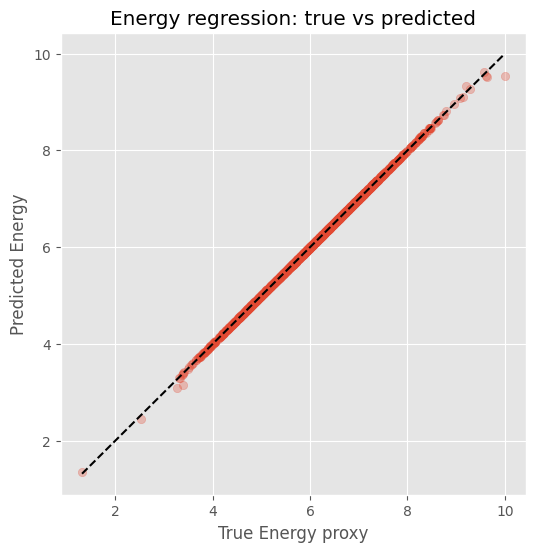

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

y_en = build_energy_target(df, k=1e-4)
X_raw, _, _ = get_feature_columns(df)

X_train, X_test, y_train, y_test = train_test_split(
    X_raw, y_en, test_size=0.2, random_state=42
)

y_pred = energy_model.predict(X_test)

print("Energy MAE:", mean_absolute_error(y_test, y_pred))
print("Energy R^2:", r2_score(y_test, y_pred))

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel("True Energy proxy")
plt.ylabel("Predicted Energy")
plt.title("Energy regression: true vs predicted")
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], "k--")
plt.show()


In [21]:
save_energy_model(energy_model, ENERGY_MODEL_PATH)
print("Energy model saved to:", ENERGY_MODEL_PATH)


Energy model saved to: /home/leo/AMOS/models/energy/energy_forecast.pkl
